In [4]:
from gscripts.clipseq import calculate_frip

%matplotlib inline
import seaborn as sns

import pysam

import pybedtools
from clipper.src import CLIP_analysis
import pandas as pd
import functools
import os
import numpy as np
from itertools import izip
from gscripts.rnaseq import splicing_map
import matplotlib.pyplot as plt

import glob
from gscripts.general import parsers
import pysam
from IPython.core.display import HTML
import fisher

from gscripts.general import dataviz
img_dir = "."

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [6]:
input_norm_dir = "/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112"
split_dir = "/home/gpratt/projects/idr/analysis/idr_v1/"
out_dir = "/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/"

In [7]:
merged_data = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/encode_v12_filelist.allencode_20160314.txt.fixedgenename.txt")

merged_data['CLIP_rep1'] = merged_data.CLIP_rep1.apply(lambda x: x.replace("/projects/ps-yeolab2/encode/analysis/encode_v12", "/projects/ps-yeolab3/encode/analysis/encode_v12"))
merged_data['CLIP_rep2'] = merged_data.CLIP_rep2.apply(lambda x: x.replace("/projects/ps-yeolab2/encode/analysis/encode_v12", "/projects/ps-yeolab3/encode/analysis/encode_v12"))

merged_data['CLIP_rep1_bam'] = merged_data.CLIP_rep1.apply(lambda x: x.replace("/projects/ps-yeolab2/encode/analysis/encode_v12", "/home/gpratt/projects/encode/analysis/softlinked_bams"))
merged_data['CLIP_rep2_bam'] = merged_data.CLIP_rep2.apply(lambda x: x.replace("/projects/ps-yeolab2/encode/analysis/encode_v12", "/home/gpratt/projects/encode/analysis/softlinked_bams"))
merged_data.CLIP_rep1_bam = merged_data.CLIP_rep1_bam.apply(lambda x: x.replace("/projects/ps-yeolab/encode/analysis/encode_v13", "/home/gpratt/projects/encode/analysis/softlinked_bams"))
merged_data.CLIP_rep2_bam = merged_data.CLIP_rep2_bam.apply(lambda x: x.replace("/projects/ps-yeolab/encode/analysis/encode_v13", "/home/gpratt/projects/encode/analysis/softlinked_bams"))
merged_data['uID_01.basedon_uID_01.peaks.l2inputnormnew.bed.compressed.bed'] = merged_data.uID.apply(lambda x: os.path.join(input_norm_dir, "{0}_01.basedon_{0}_01.peaks.l2inputnormnew.bed.compressed.bed.annotated".format(x)))
merged_data['uID_02.basedon_uID_02.peaks.l2inputnormnew.bed.compressed.bed'] = merged_data.uID.apply(lambda x: os.path.join(input_norm_dir, "{0}_02.basedon_{0}_02.peaks.l2inputnormnew.bed.compressed.bed.annotated".format(x)))

merged_data['clip_split_rep1'] = merged_data.CLIP_rep1.apply(lambda x: os.path.join(split_dir, "{}.01.peaks.norm.compressed.l2Fixed.bed".format(os.path.splitext(os.path.basename(x))[0])))
merged_data['clip_split_rep2'] = merged_data.CLIP_rep2.apply(lambda x: os.path.join(split_dir, "{}.01.peaks.norm.compressed.l2Fixed.bed".format(os.path.splitext(os.path.basename(x))[0])))

In [2]:
calculate_frip.compute_frip("/projects/ps-yeolab/encode/analysis/encode_v13/587_02_RBM8A.merged.r2.bam", 
                            "/home/gpratt/clipper/clipper/data/regions/hg19_genes.bed")

(658702, 687075L, 0.9587046537859768)

In [53]:
exons = "/home/gpratt/clipper/clipper/data/regions/hg19_exons.bed"
introns = "/home/gpratt/clipper/clipper/data/regions/hg19_introns.bed"

In [54]:
def compute_frip(bam, bed, order=None):
    
    bam_tool = pybedtools.BedTool(bam)
    peaks = pybedtools.BedTool(bed)

    if order:
        peaks = peaks.sort(faidx=order).saveas()

    num_reads_peaks = len(bam_tool.intersect(peaks, u=True, s=True))

    bamtool = pysam.Samfile(bam)
    
    total_mapped_reads = bamtool.mapped
    return num_reads_peaks, total_mapped_reads, (float(num_reads_peaks) / total_mapped_reads)

In [57]:
upf1 = merged_data[merged_data.RBP == "UPF1"].CLIP_rep1.values[0]
#upf1 = "/projects/ps-yeolab/encode/analysis/encode_v13/587_02_RBM8A.merged.r2.bam"

num_exon_reads, total_reads, exon_frip = calculate_frip.compute_frip(upf1, 
                            exons)

In [61]:
rbfox2 = merged_data[merged_data.RBP == "RBFOX2"].CLIP_rep1.values[0]
#upf1 = "/projects/ps-yeolab/encode/analysis/encode_v13/587_02_RBM8A.merged.r2.bam"

num_exon_reads_rbfox2, total_reads_rbfox2, exon_frip_rbfox2 = calculate_frip.compute_frip(rbfox2, 
                            exons)

In [70]:
fn ="/projects/ps-yeolab2/encode/analysis/encode_v12/300_CLIP_GAGATTCC-TAATCTTA_L001_R1.A03_300_02_FXR1.adapterTrim.round2.rmRep.bamSJ.out.tab"

In [76]:
def parse_star_tab(fn):
    sj_overhang_reads = pd.read_table(fn,
                                      header=None, names=['chrom', 'first_base', 'last_base', 'strand', 'motif', 'annotated', 'unique_reads', 'multimapped_reads', 'sj_overhang'])
    return sj_overhang_reads

In [89]:
sj_reads = glob.glob("/projects/ps-yeolab3/encode/analysis/encode_master/*.round2.rmRep.bamSJ.out.tab")
sj_reads = parsers.get_names(sj_reads, 2, ".")

In [103]:
foo = {name: parse_star_tab(cutadapt_file).unique_reads.sum() for name, cutadapt_file in sj_reads.items()}
foo = pd.DataFrame(pd.Series(foo, name="count"))
foo['group_name'] = foo.index.map(lambda x: "_".join(x.split(".")[1].split("_")[1:]))

summed_counts = foo.groupby("group_name").sum()
summed_counts["bam_file"] = summed_counts.index.map(lambda x: "/projects/ps-yeolab2/encode/analysis/encode_master/" + x + ".merged.r2.bam")

In [125]:
def count_total_reads(fn):
    try:
        return pysam.Samfile(fn).mapped
    except: 
        return np.nan

In [126]:
summed_counts['bam_reads'] = summed_counts.bam_file.apply(count_total_reads)
summed_counts['fraction_spanning'] = summed_counts['count'] / summed_counts.bam_reads

In [135]:
HTML(summed_counts.sort_values("fraction_spanning").to_html())

,count,bam_file,bam_reads,fraction_spanning
group_name,,,,
243_02_backup_LARP7,0,/projects/ps-yeolab2/encode/analysis/encode_ma...,101.0,0.000000
LNG12-N_INPUT_A04F05_ELAVL1,12422,/projects/ps-yeolab2/encode/analysis/encode_ma...,9355775.0,0.001328
LNG16-E_CLIP_HNRNPM,9681,/projects/ps-yeolab2/encode/analysis/encode_ma...,5907739.0,0.001639
LNG14-N_CLIP_HNRNPA1,16095,/projects/ps-yeolab2/encode/analysis/encode_ma...,9579240.0,0.001680
LNG12-N_CLIP_ELAVL1,8762,/projects/ps-yeolab2/encode/analysis/encode_ma...,4823166.0,0.001817
LNG16-N_CLIP_HNRNPM,4823,/projects/ps-yeolab2/encode/analysis/encode_ma...,2368687.0,0.002036
222_02_HNRNPM,7358,/projects/ps-yeolab2/encode/analysis/encode_ma...,3291517.0,0.002235
SEB9_HUR,23113,/projects/ps-yeolab2/encode/analysis/encode_ma...,9385640.0,0.002463
271_01_HNRNPC,44184,/projects/ps-yeolab2/encode/analysis/encode_ma...,15153574.0,0.002916


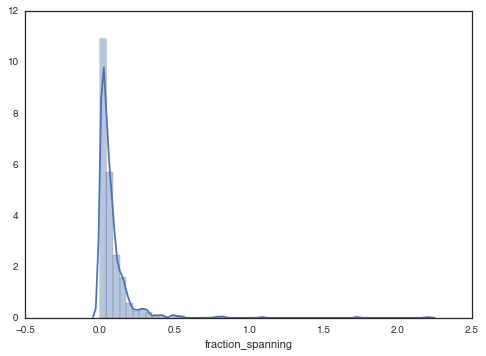

In [137]:
sns.distplot(summed_counts.fraction_spanning.dropna())

That didn't work well, still not quite the bimodal distribution I expected, there are two options here, calculate the frip for inputs and get the ratio, or directly count enriched peaks

In [141]:
exons_dir = "/home/gpratt/projects/encode/analysis/exon_binding"

In [160]:
def frip(metrics_files):
    try:
        return pd.read_table(metrics_files).FRiP[0]    
    except:
        return np.nan
    
def format_in_genes(fn):
    fn = os.path.join(exons_dir, os.path.basename(fn).replace("bam", "in_genes.metrics"))
    return frip(fn)

In [164]:
merged_data['clip_split_rep1'] = merged_data.CLIP_rep1.apply(format_in_genes)
merged_data['clip_split_rep2'] = merged_data.CLIP_rep2.apply(format_in_genes)
merged_data['clip_input'] = merged_data.INPUT.apply(format_in_genes)

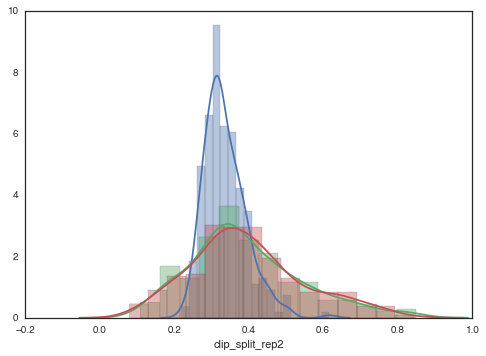

In [168]:
sns.distplot(merged_data.clip_input)
sns.distplot(merged_data.clip_split_rep1.dropna())
sns.distplot(merged_data.clip_split_rep2.dropna())

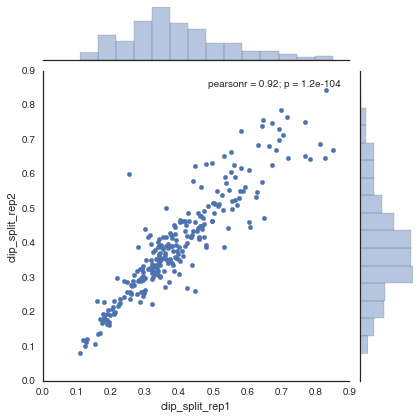

In [170]:
sns.jointplot("clip_split_rep1", "clip_split_rep2", data=merged_data)

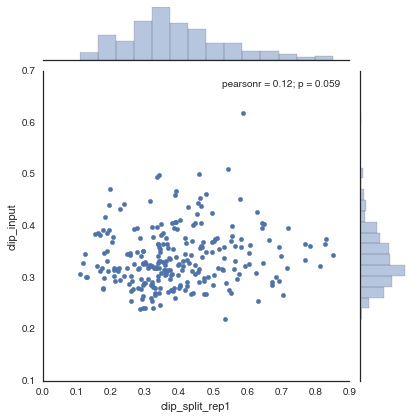

In [171]:
sns.jointplot("clip_split_rep1", "clip_input", data=merged_data)

In [173]:
merged_data['fold_enriched'] = merged_data.clip_split_rep1 / merged_data.clip_input

In [185]:
localization = pd.read_csv("/home/gpratt/Dropbox/Pratt,Gabriel/PapersInProgress/eCLIP_qc/data/RBP Localization Matrix_March 2015.csv")

In [198]:
nuclei = localization[localization.Nuclei == 1]
cytoplasm = localization[localization.Cytoplasm == 1]

In [182]:
HTML(merged_data.sort_values("fold_enriched")[['RBP', 'Cell line', 'fold_enriched']].to_html())

,RBP,Cell line,fold_enriched
136,NSUN2,K562,0.352482
14,HNRNPM,HepG2,0.353342
1,HNRNPC,HepG2,0.357280
60,NONO,HepG2,0.398930
127,SFPQ,HepG2,0.412591
51,HNRNPA1,HepG2,0.418321
104,HNRNPA2B1,HepG2,0.418333
135,ILF2,K562,0.425334
187,RPLP0,HepG2,0.431747
250,HNRNPA2B1,HepG2,0.433624


In [210]:
merged_data[merged_data.RBP.isin(nuclei[' RBP'])]

,uID,RBP,Cell line,CLIP_rep1,CLIP_rep2,INPUT,CLIP_rep1_bam,CLIP_rep2_bam,uID_01.basedon_uID_01.peaks.l2inputnormnew.bed.compressed.bed,uID_02.basedon_uID_02.peaks.l2inputnormnew.bed.compressed.bed,clip_split_rep1,clip_split_rep2,clip_input,fold_enriched
0,202,PTBP1,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/home/elvannostrand/data/clip/CLIPseq_analysis...,/home/elvannostrand/data/clip/CLIPseq_analysis...,0.226584,0.236935,0.433199,0.523048
1,203,HNRNPC,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/home/elvannostrand/data/clip/CLIPseq_analysis...,/home/elvannostrand/data/clip/CLIPseq_analysis...,0.117339,0.117138,0.328424,0.357280
2,204,RBFOX2,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/home/elvannostrand/data/clip/CLIPseq_analysis...,/home/elvannostrand/data/clip/CLIPseq_analysis...,0.293003,0.257898,0.350972,0.834833
4,206,HNRNPK,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/home/elvannostrand/data/clip/CLIPseq_analysis...,/home/elvannostrand/data/clip/CLIPseq_analysis...,0.246222,0.256322,0.346115,0.711388
5,209,SRSF7,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/home/elvannostrand/data/clip/CLIPseq_analysis...,/home/elvannostrand/data/clip/CLIPseq_analysis...,0.400879,0.466262,0.410242,0.977177
8,214,IGF2BP2,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/home/elvannostrand/data/clip/CLIPseq_analysis...,/home/elvannostrand/data/clip/CLIPseq_analysis...,0.445336,0.623983,0.404810,1.100112
10,216,SRSF9,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/home/elvannostrand/data/clip/CLIPseq_analysis...,/home/elvannostrand/data/clip/CLIPseq_analysis...,0.479738,0.395224,0.460568,1.041623
11,218,TRA2A,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/home/elvannostrand/data/clip/CLIPseq_analysis...,/home/elvannostrand/data/clip/CLIPseq_analysis...,0.511583,0.550052,0.375639,1.361901
15,223,FKBP4,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/home/elvannostrand/data/clip/CLIPseq_analysis...,/home/elvannostrand/data/clip/CLIPseq_analysis...,0.301674,0.351855,0.325233,0.927561
18,226,IGF2BP2,K562,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/anal

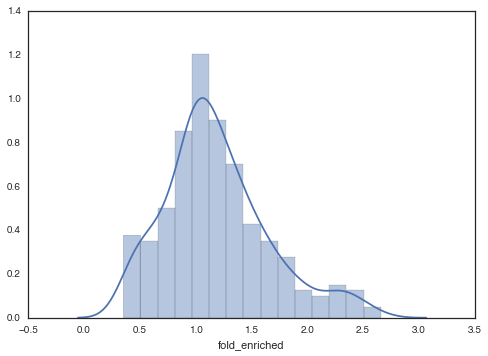

In [180]:
sns.distplot(merged_data.fold_enriched.dropna())

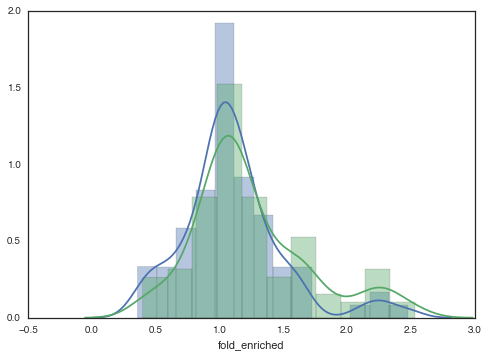

In [213]:
sns.distplot(merged_data[merged_data.RBP.isin(nuclei[' RBP'])].fold_enriched.dropna())
sns.distplot(merged_data[merged_data.RBP.isin(cytoplasm[' RBP'])].fold_enriched.dropna())

# Broad vs narrow peak size

In [306]:
hg19_genes = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_genes.bed")
gene_lengths = {interval.name: len(interval) for interval in hg19_genes}
gene_lengths = pd.Series(gene_lengths)
hg19_windows = pybedtools.BedTool("/home/gpratt/projects/encode/analysis/ad-hoc/windowing_enrichment/hg19_windows_100.bed")

In [307]:
def fold_enrichment_coverage(ip_file, input_file, hg19_windows):
    ip_bamtool = pybedtools.BedTool(ip_file)
    input_bamtool = pybedtools.BedTool(input_file)
    
    ip_tool = hg19_windows.coverage(ip_bamtool, counts=True)
    input_tool = hg19_windows.coverage(input_bamtool, counts=True)
    
    ip_mapped_reads = pysam.Samfile(ip_file).mapped
    input_mapped_reads = pysam.Samfile(input_file).mapped

    ip_mapped_reads /= 1000000.
    input_mapped_reads /= 1000000.
    
    ip_df = ip_tool.to_dataframe()
    input_df = input_tool.to_dataframe()
    
    ip_df['normalized_score'] = (ip_df.score + 1) / ip_mapped_reads
    input_df['normalized_score'] = (input_df.score + 1) / input_mapped_reads
    ip_df['region_length'] = ip_df.end - ip_df.start
    ip_df['normalized_input_score'] = input_df.normalized_score
    ip_df['input_score'] = input_df.score

    
    ip_df['log2_fold_enrichment'] = np.log2(ip_df.normalized_score  / input_df.normalized_score)
    return ip_df

In [308]:
ip_df_dgcr8 = fold_enrichment_coverage("/projects/ps-yeolab3/encode/analysis/encode_master/341_01_DGCR8.merged.r2.bam",
                         "/projects/ps-yeolab3/encode/analysis/encode_master/341_INPUT_TCCGGAGA-CCTATCCT_L002_R1.unassigned.adapterTrim.round2.rmRep.rmDup.sorted.r2.bam",
                            hg19_windows)

ip_df_dgcr8['fisher'] = ip_df_dgcr8.apply(lambda x: fisher.pvalue(x.score, ip_counts, x.input_score, input_counts).two_tail, axis=1)
filtered_df = ip_df_dgcr8[(ip_df_dgcr8.fisher < .001) & (ip_df_dgcr8.log2_fold_enrichment > 2)]

In [309]:
result = []
for name, x in filtered_df.iterrows():
    result.append(pybedtools.create_interval_from_list([x.chrom, 
                                                        str(x.start), 
                                                        str(x.end)]))
result = pybedtools.BedTool(result)

In [313]:
merged_result = result.sort().merge()

In [318]:
merged_result.filter(lambda x: len(x) > 4000).saveas().head(n=100)

chr13	91999900	92007700
 chr17	56405200	56409900
 chr19	13948900	13953800
 chr22	20067700	20076300
 chr22	42294800	42300000
 chr9	96934600	96941900
 chr9	139557400	139569000
 

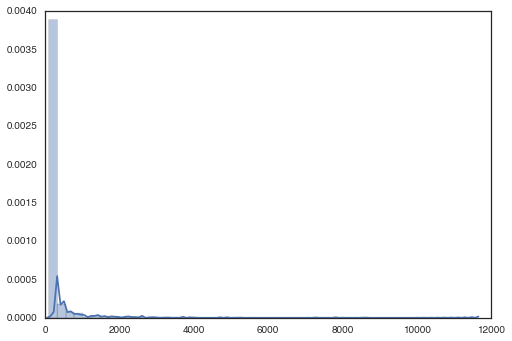

In [310]:
sns.distplot([len(interval) for interval in result.sort().merge()])

In [319]:
np.mean([len(interval) for interval in result.sort().merge()])

239.43548387096774

In [320]:
np.median([len(interval) for interval in result.sort().merge()])

100.0

In [321]:
ip = merged_data[merged_data.RBP == "TAF15"].ix[80].CLIP_rep1
input_fn = merged_data[merged_data.RBP == "TAF15"].ix[80].INPUT

In [322]:
taf15_df = fold_enrichment_coverage(ip, input_fn,
                            hg19_windows)

taf15_df['fisher'] = taf15_df.apply(lambda x: fisher.pvalue(x.score, ip_counts, x.input_score, input_counts).two_tail, axis=1)
filtered_taf15_df = taf15_df[(taf15_df.fisher < .00001) & (taf15_df.log2_fold_enrichment > 2)]

In [335]:
filtered_taf15_df = taf15_df[(taf15_df.fisher < .00001) & (taf15_df.log2_fold_enrichment > 3)]

In [341]:
result = []
for name, x in filtered_taf15_df.iterrows():
    result.append(pybedtools.create_interval_from_list([x.chrom, 
                                                        str(x.start), 
                                                        str(x.end)]))
result = pybedtools.BedTool(result)

In [342]:
filtered_taf15_df

,chrom,start,end,name,score,normalized_score,region_length,normalized_input_score,input_score,log2_fold_enrichment,fisher
6814,chr1,681400,681500,chr1,15,3.287514,100,0.204605,0,4.006083,1.177019e-06
12034,chr1,1203400,1203500,chr1,21,4.520331,100,0.409210,1,3.465514,6.776290e-08
12036,chr1,1203600,1203700,chr1,24,5.136740,100,0.613815,2,3.064976,3.992576e-08
12054,chr1,1205400,1205500,chr1,28,5.958618,100,0.613815,2,3.279101,1.391641e-09
12057,chr1,1205700,1205800,chr1,16,3.492983,100,0.409210,1,3.093545,5.002595e-06
12079,chr1,1207900,1208000,chr1,28,5.958618,100,0.613815,2,3.279101,1.391641e-09
12080,chr1,1208000,1208100,chr1,31,6.575027,100,0.613815,2,3.421120,1.096353e-10
15818,chr1,1581800,1581900,chr1,14,3.082044,100,0.204605,0,3.912973,2.924582e-06
16891,chr1,1689100,1689200,chr1,18,3.903922,100,0.409210,1,3.254010,9.019746e-07
16892,chr1,1689200,1689300,chr1,27,5.753149,100,0.409210,1,3.813438,3.641488e-10


In [347]:
[len(interval) for interval in result.sort().merge()]

[100,
 100,
 100,
 100,
 100,
 200,
 100,
 200,
 100,
 100,
 100,
 100,
 300,
 100,
 100,
 200,
 100,
 100,
 200,
 200,
 200,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 400,
 200,
 100,
 100,
 100,
 100,
 100,
 100,
 200,
 100,
 200,
 200,
 100,
 200,
 100,
 100,
 300,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 200,
 200,
 100,
 200,
 100,
 100,
 100,
 100,
 200,
 100,
 200,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 200,
 100,
 100,
 100,
 100,
 400,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 200,
 100,
 200,
 200,
 200,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 200,
 100,
 100,
 100,
 100,
 100,
 200,
 200,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 300,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 700,
 100,
 200,
 200,
 100,
 100,
 100,
 300,
 200,
 100,
 100,
 100,
 100,
 100,
 200,
 100,
 100,
 100,
 200,
 100,
 100

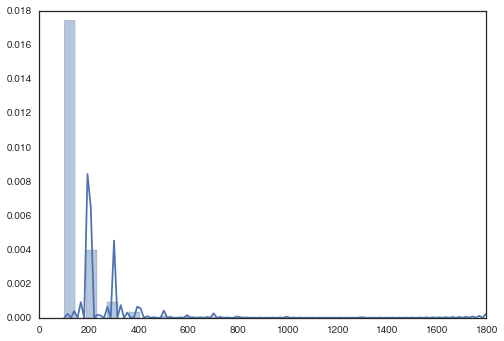

In [343]:
sns.distplot([len(interval) for interval in result.sort().merge()])

In [344]:
np.mean([len(interval) for interval in result.sort().merge()])

137.36120182887001

In [345]:
np.median([len(interval) for interval in result.sort().merge()])

100.0